# Lecture 8 - Full-Waveform Inversion (FWI)

To complete the trilogy of FWI lectures, we will use what we have learned in the previous sessions to implement an FWI problem in Devtio and highlight the core ideas behind the implementation of seismic inversion problems (where we create an image of the subsurface from field recorded data) in general.

## Inversion requirements

To recap, seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

Using the method of *steepest descent*, in its
simplest form, the FWI algorithm consists of the following steps:
1. start from a model $\mathbf{m}_0$ (the initial velocity model),
2. evaluate the gradient of the objective function, $\nabla\phi(\mathbf{m})$, for the current model,
3. find the step length $\alpha$,
4. subtract $\alpha$ times the gradient from the current model to obtain a new model,
5. iterate from step 2 using the new model until the objective function is sufficiently small (or we run out of patience).

That is, we need to implement the model update scheme

\begin{equation}
 \mathbf{m}_{n+1}=\mathbf{m}_n-\alpha\nabla_{\mathbf{m}}f.
\end{equation}

## Notes on the operators

As we have already described the creation of a forward modelling operator, we will only call a wrapper function here. This wrapper already contains all the necessary operators for seismic modeling, imaging and inversion. Operators introduced for the first time in this tutorial will be properly described.

In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING' # This added simply to reduce clutter in the output

## Computational considerations

As we will see, FWI is computationally extremely demanding. To keep this tutorial as lightweight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [2]:
nshots = 9  # Number of shots to used to generate the gradient
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

# True and smooth (initial) velocity models

We will use a very simple model domain, consisting of a circle within a 2D domain. We will again use the "true" model to generate our synthetic shot data and use a "smooth" model as our initial guess. In this case the smooth model is very smooth indeed - it is simply a constant background velocity without any features.

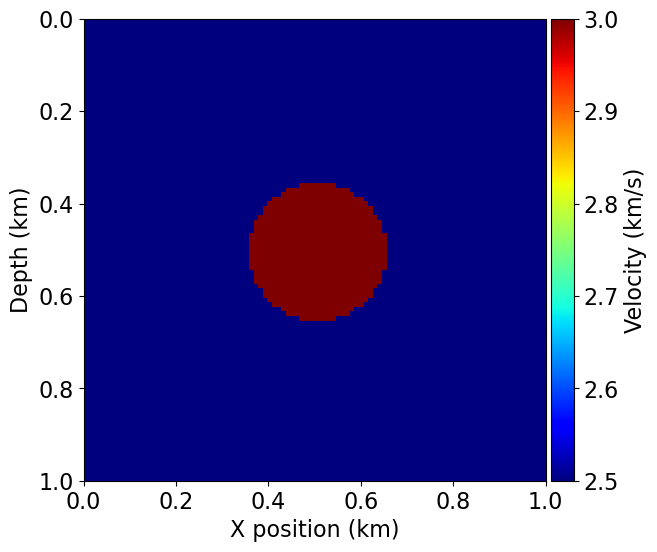

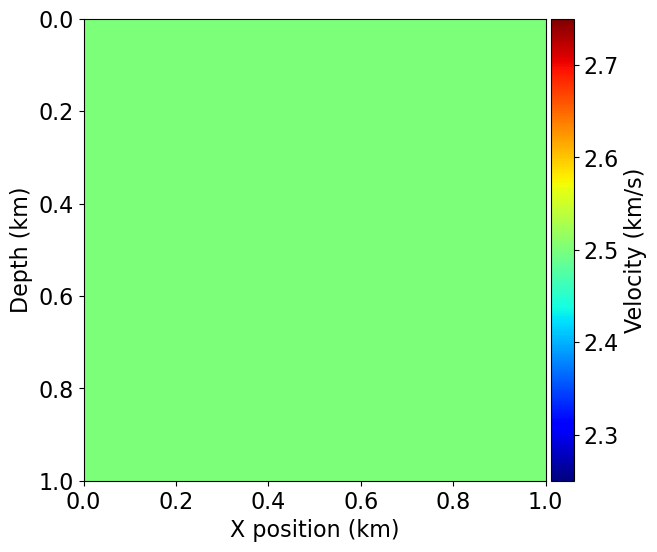

In [3]:
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

# True model - Used to generate the 'field' data
model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

# Smooth (initial) model - Used to generate our model/synthetic data
model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                    grid = model.grid)

plot_velocity(model)
plot_velocity(model0)

## Acquisition geometry

In this tutorial, we will use the simplest case for inversion, namely a transmission experiment. The source(s) will be located on one side of the model and the receivers on the other side. This allows most of the information necessary for inversion to be recorded, since reflections usually lead to poor inversion results.

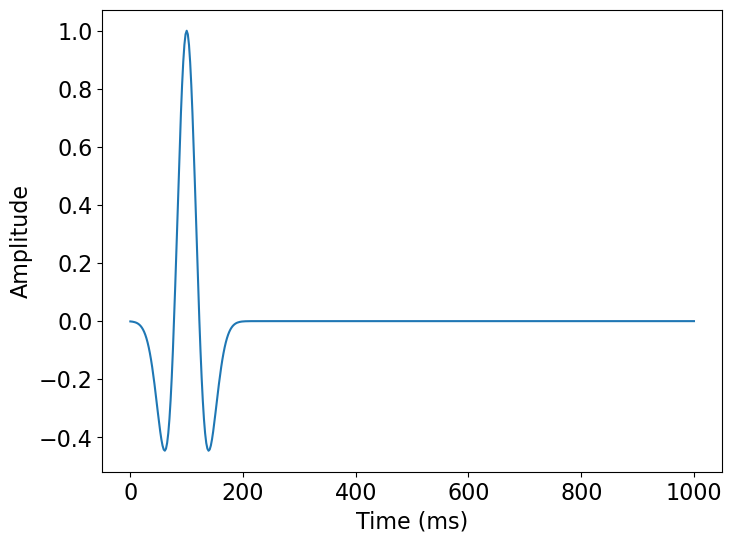

In [4]:
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

t0 = 0.
tn = 1000. 
f0 = 0.010
# Position the source:
src_coordinates = np.empty((1, 2))
src_coordinates[0, 1] = np.array(model.domain_size[1]) * .5
src_coordinates[0, 0] = 20.

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

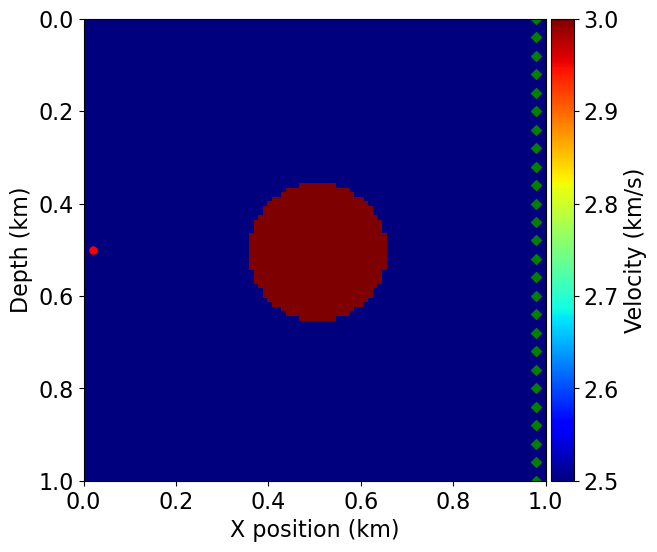

In [5]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

# Full-Waveform Inversion

As we noted previously, our inversion frame work will be based on solving the following boundary value problem for the second order acoustic wave-equation:

\begin{align*}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\nabla^2 u = s, \\
  u(\mathbf{x},0)=0, \\
  \frac{\partial u}{\partial t}(\mathbf{x},0)=0.
\end{align*}

The wave equation represents a linear relationship between a wavefield $u$ and the source $s$ that generates the wavefield. After discretisation (with for example finite differences) we can therefore write $\eqref{eq:we0}$ as a matrix equation

\begin{equation}
  \mathbf{A}\mathbf{u}=\mathbf{s},
\end{equation}

where $\mathbf{u}$ and $\mathbf{s}$ are column vectors that represent the source and wavefield at discrete points
in space and time, and $\mathbf{A}$ is a matrix that represents the discrete numerical implementation of the operator

\begin{equation}
  \frac{1}{c^2}\frac{\partial^2}{\partial t^2}-\nabla^2.
\end{equation}

Although the wave equation represents a linear relationship between $u$ and $s$, it also represents a non-linear relationship between a model $\mathbf{m}$ and wavefield $\mathbf{u}$. Thus we can also write the wave equation as

\begin{equation}
  G(\mathbf{m})=\mathbf{u}.
\end{equation}

Here $\mathbf{m}$ is a column vector that contains the model parameters. Commonly these will be the values of $c$ at every point in the model, but they may be any set of parameters that is sufficient to describe the model, for example squared slownesses $1/c^2$. Note that in equation $\eqref{eq:we4}$ $G$ is not a matrix; it is a (non-linear) function that describes how to calculate a wavefield $\mathbf{u}$ given a model $\mathbf{m}$.

Note that the form of matrix $\mathbf{A}$ depends upon both the model properties and the details of the numerical implementation, and that the form of the function $G$ depends upon the source and the acquisition geometry. The form of $\mathbf{A}$ does not depend upon the source and the form of $G$ does not depend upon the model.

It is common in FWI to construct the numerical wave equation in $\eqref{eq:we1}$ such that the matrix
$\mathbf{A}$ represents a wave travelling forward in time, and its transpose represents a wave travelling
backwards in time. This is not essential, but it is often straightforward to achieve, in which
case it simplifies the numerics of FWI.

## True and smooth data

We can generate shot records for the true and smoothed initial velocity models, since the difference between them will again form the basis of our imaging procedure.

In [6]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)

In [7]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

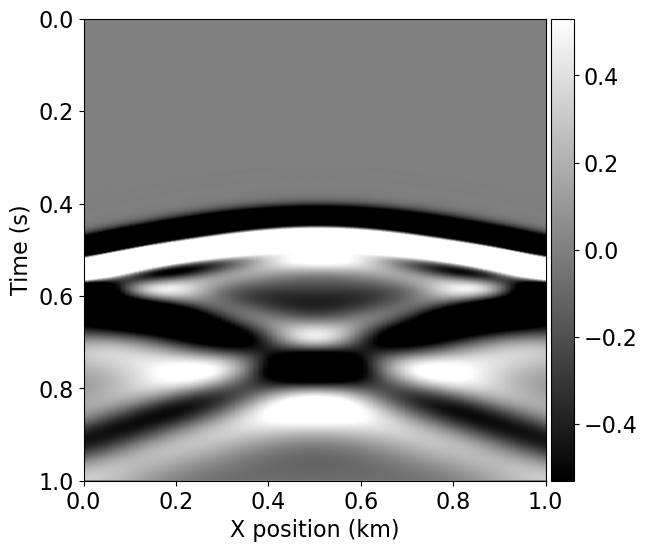

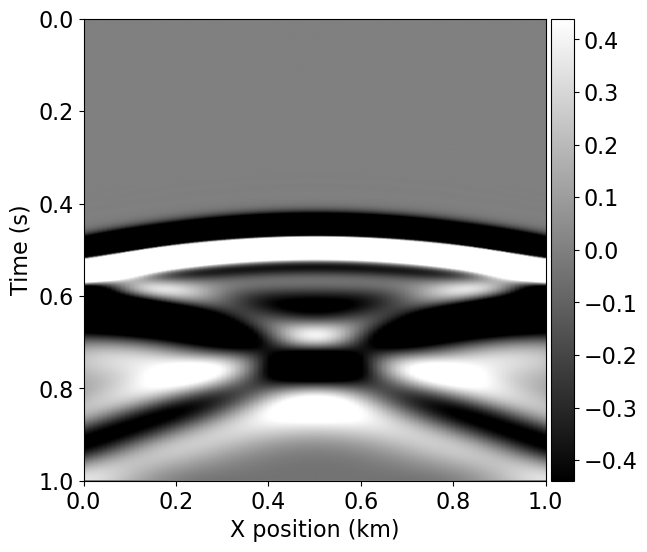

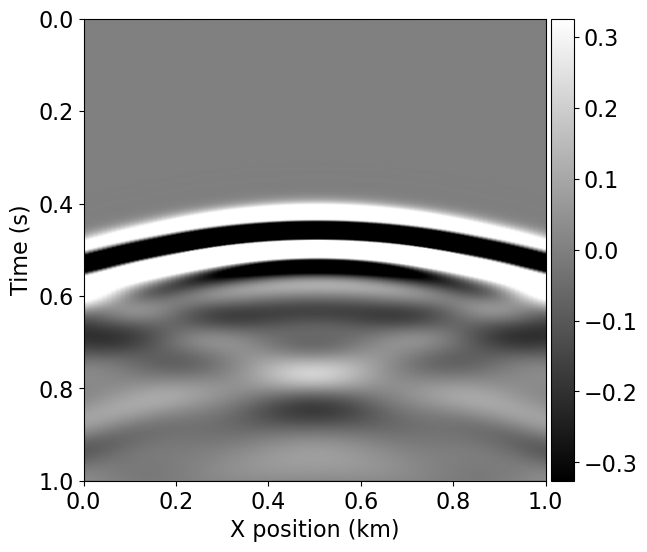

In [8]:
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

## Formulation

Recall that our objective function is chosen to be the $L_2-norm$ of the residual data (which is the modelled/predicted/synthetic data - predicated/observed data):

\begin{equation}
  \phi(\mathbf{m})=\frac{1}{2}||\mathbf{p}-\mathbf{d}||^2=\frac{1}{2}||\delta\mathbf{d}||^2=\frac{1}{2}\delta\mathbf{d}^{T}\delta\mathbf{d}=\frac{1}{2}\sum_{n_s}\sum_{n_r}\sum_{n_t}|p-d|^2,
\end{equation}

where $n_s$, $n_r$ and $n_t$ are the number of sources, receivers and time samples in the data set,
and $\mathbf{d}$ and $\mathbf{p}$ are the observed and predicted datasets.

The procedure is therefore, given an initial velocity model and observed data set, to minimize $\phi(\mathbf{m})$. For our steepest descent loop, we'll need the gradient of $\phi(\mathbf{m})$ which is given by

\begin{equation}
  \nabla\phi(\mathbf{m})=\frac{\partial f}{\partial \mathbf{m}}=\frac{\partial}{\partial \mathbf{m}}\left(\frac{1}{2}\delta\mathbf{d}^T\delta\mathbf{d}\right)=\frac{\partial (\mathbf{p}-\mathbf{d})^T}{\partial \mathbf{m}}\delta\mathbf{d}=\left(\frac{\partial \mathbf{p}}{\partial \mathbf{m}}\right)^T\delta\mathbf{d}.
\end{equation}

or

\begin{equation}
  \nabla\phi(\mathbf{m})=-\mathbf{u}^{T}\left(\frac{\partial\mathbf{A}}{\partial\mathbf{m}}\right)^T\delta\mathbf{u},
\end{equation}

where $\delta\mathbf{u}$ is the residual wavefield.

## FWI gradient operator

To compute a single gradient $\nabla\phi(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to encode a similar procedure to the previous imaging tutorial as our gradient calculation:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

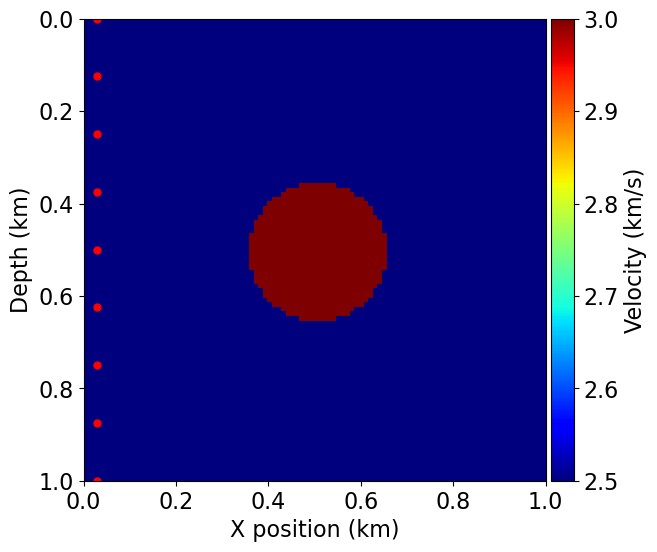

In [9]:
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [10]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

In [11]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis, 
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad

## Model updates

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the gradient alongside the model perturbation and the effect of the gradient update on the model.

In [12]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
assert np.isclose(ff, 57283, rtol=1e0)

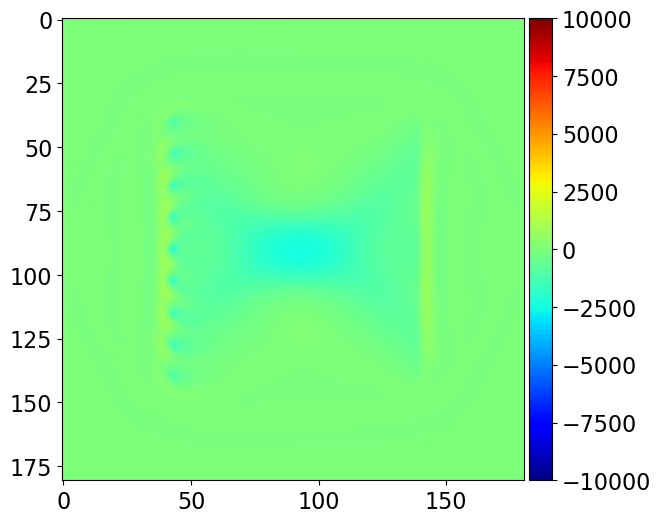

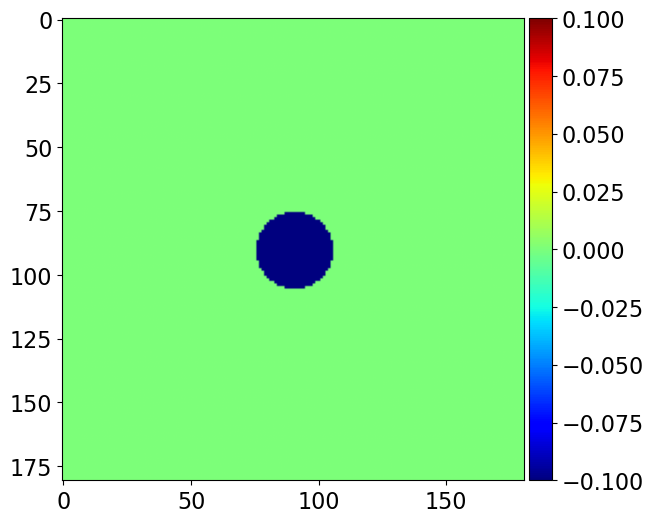

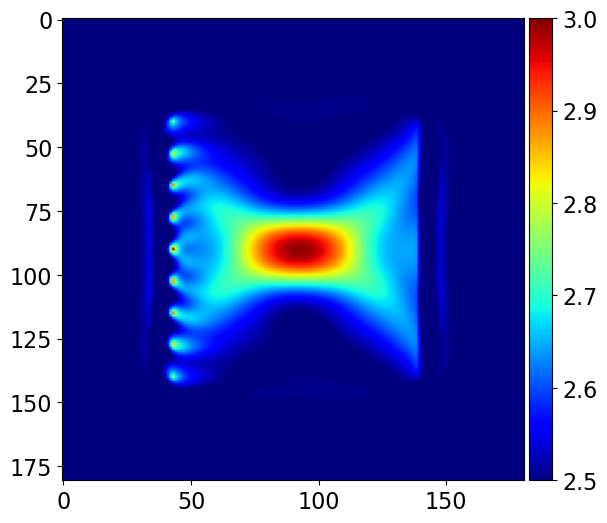

In [13]:
#NBVAL_IGNORE_OUTPUT
from devito import mmax
from examples.seismic import plot_image

# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

### Steepest/Gradient Descent

Lets now implement some functions for our steepest descent scheme.

In [14]:
from sympy import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [15]:
#NBVAL_SKIP

from devito import mmax

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    # Store the history of the functional values
    history[i] = phi

    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / mmax(direction)
    
    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

vp(x, y)
Objective value is 39293.339844 at iteration 1
vp(x, y)
Objective value is 24506.068359 at iteration 2
vp(x, y)
Objective value is 14386.169922 at iteration 3
vp(x, y)
Objective value is 7907.213867 at iteration 4
vp(x, y)
Objective value is 3959.856201 at iteration 5


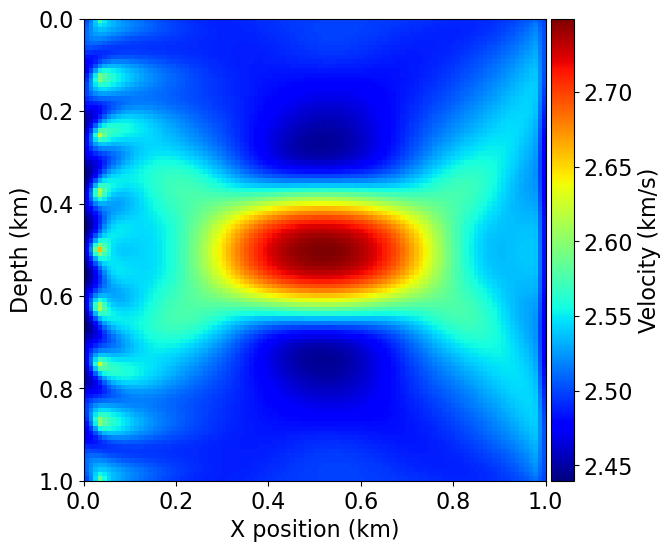

In [16]:
#NBVAL_IGNORE_OUTPUT

# Plot inverted velocity model
plot_velocity(model0)

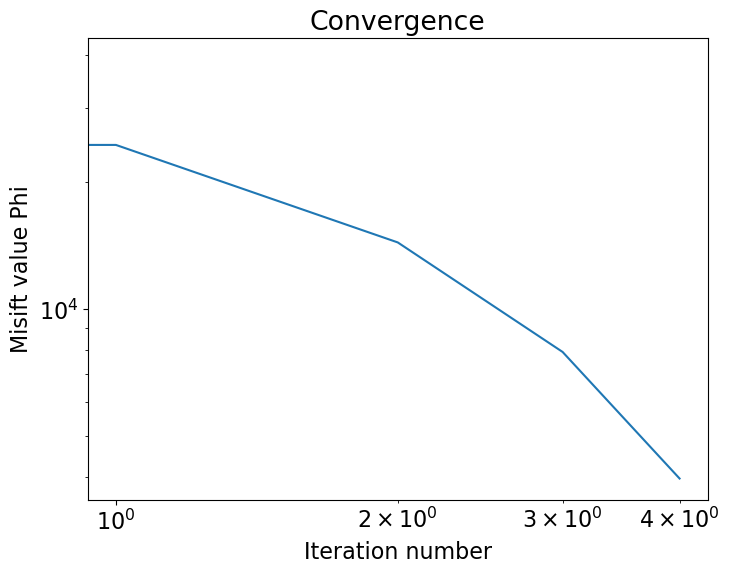

In [17]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## Final remarks

We now have the outline of a framework for performing FWI. It should be noted that in real scenario's, many practical issues pop-up.

For a more detailed discussion and further references regarding such practical issues, see the paper entitled 'Anisotropic 3D full-waveform inversion' (located in the `additional_material` folder). **Note that you should read this paper carefully in your own time**.

Some highlights are discussed below:
- Filtering: For real data sets, the observed data sets are often filtered (via e.g. Weiner Filters) prior to inversion, so that inversion is first carried out for lower frequency waveband's. Inversion of higher frequency waveband's is then carried out later.
- Cycle skipping: This is quite a troublesome phenomenon! If arrival times in model data are out a half a wavelength, the minimization algorithm can often lead to parts of the wavefield's being erroneously eliminated. Thus, great care needs to be taken to ensure arrival times are accurate (and numerical dispersion is minimized). This can done by forming finite difference stencils based on Fourier transforms (instead of Taylor series).
- Inversion crime: In this notebook we have committed inversion crime (in order to keep things simple). A better method would be to produce the synthetics using a higher fidelity (e.g. elastic) wave-equation.

## Preparing for the exam

In preparing for the exam, make sure you
- Understand gradient descent schemes (and how to derive them starting from Taylor series expansions).
- Understand how gradient descent schemes relate to FWI algorithms.
- Understand the basics of the finite difference method:
    - How to manipulate the Taylor series to derive approximations for derivatives.
    - Given a time dependent PDE, how to utilize the finite difference method to derive time-stepping schemes.
- Overview of the FWI including applications, data sets involved, what the objective function is, algorithmic procedure etc.

What you wont need to know
- Mathematics of computing the gradient of the objective function.
- Anything specific about Devito.

## References

[1] _Virieux, J. and Operto, S.: An overview of full-waveform inversion in exploration geophysics, GEOPHYSICS, 74, WCC1–WCC26, doi:10.1190/1.3238367, http://library.seg.org/doi/abs/10.1190/1.3238367, 2009._

[2] _Haber, E., Chung, M., and Herrmann, F. J.: An effective method for parameter estimation with PDE constraints with multiple right hand sides, SIAM Journal on Optimization, 22, http://dx.doi.org/10.1137/11081126X, 2012._